In [ ]:
# install dependencies and download dataset
#!git clone https://github.com/bowang-lab/MedSAM2.git
#%cd MedSAM2
#%pip install -e .
# Download dataset
#!mkdir -p images
#folder_id = "19_fsP6zRm2nWGiPy2hEktE4rJ9SvrWsb"
#!gdown --folder https://drive.google.com/drive/folders/{folder_id} -O images
# download checkpoints
#!mkdir -p checkpoints
#!gdown https://drive.google.com/uc?id=1Kw2G_giDae8JG4kasYS-MUVzzKW4gfSG -O ./checkpoints/MedSAM2_latest.pt
#!wget -P checkpoints https://huggingface.co/wanglab/MedSAM2/resolve/main/MedSAM2_2411.pt
#download dataset
#!wget -P data --content-disposition "https://huggingface.co/datasets/wanglab/CT_DeepLesion-MedSAM2/resolve/main/images255/000083_04_01_109-121_0000.nii.gz?download=true"
#!wget -P data --content-disposition "https://huggingface.co/datasets/wanglab/CT_DeepLesion-MedSAM2/resolve/main/DeepLesion_Dataset_Info.csv?download=true"



Cloning into 'MedSAM2'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 291 (delta 58), reused 41 (delta 41), pack-reused 199 (from 1)
Receiving objects: 100% (291/291), 18.82 MiB | 9.66 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/home/usagers/u139017/proyectos/Medsam/MedSAM2
Obtaining file:///home/usagers/u139017/proyectos/Medsam/MedSAM2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for MedSAM2 (pyproject.toml) ... done
  Created wheel for MedSAM2: filename=medsam2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=10586 sha256=140d6cc325b00535f569014499ce352d9c5b601d940840d82b7f8a0886e29026
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhrpn9jh/wheels/f9/60/f0/e318a1764bbec7947b2cfc4dd27b4c17

In [24]:
# load libraries and define necessary functions
from glob import glob
from tqdm import tqdm
import os
from os.path import join, basename
import re
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import numpy as np
import argparse

from PIL import Image
import SimpleITK as sitk
import torch
import torch.multiprocessing as mp
from sam2.build_sam import build_sam2_video_predictor_npz
import SimpleITK as sitk
from skimage import measure, morphology


In [25]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)

In [81]:
def getLargestCC(segmentation):
    labels = measure.label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """
    show mask on the image

    Parameters
    ----------
    mask : numpy.ndarray
        mask of the image
    ax : matplotlib.axes.Axes
        axes to plot the mask
    mask_color : numpy.ndarray
        color of the mask
    alpha : float
        transparency of the mask
    """
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, edgecolor='blue'):
    """
    show bounding box on the image

    Parameters
    ----------
    box : numpy.ndarray
        bounding box coordinates in the original image
    ax : matplotlib.axes.Axes
        axes to plot the bounding box
    edgecolor : str
        color of the bounding box
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0,0,0,0), lw=2))


def resize_grayscale_to_rgb_and_resize(array, image_size):
    """
    Resize a 3D grayscale NumPy array to an RGB image and then resize it.

    Parameters:
        array (np.ndarray): Input array of shape (d, h, w).
        image_size (int): Desired size for the width and height.

    Returns:
        np.ndarray: Resized array of shape (d, 3, image_size, image_size).
    """
    d, h, w = array.shape
    resized_array = np.zeros((d, 3, image_size, image_size))

    for i in range(d):
        img_pil = Image.fromarray(array[i].astype(np.uint8))
        img_rgb = img_pil.convert("RGB")
        img_resized = img_rgb.resize((image_size, image_size))
        img_array = np.array(img_resized).transpose(2, 0, 1)  # (3, image_size, image_size)
        resized_array[i] = img_array

    return resized_array

Please specify the following:

--checkpoint: model checkpoint
--imgs_path: path to the 3D volume in nii.gz format
--model_cfg: model config path
--pred_save_dir: path to save the inference results
--path_DL_info: path to the CT lesion key slices info

In [82]:
# Set paths to the model checkpoint, image directory, and dataset information of the bounding boxes
checkpoint = '/home/usagers/u139017/proyectos/Medsam/MedSAM2/checkpoints/MedSAM2_2411.pt'
imgs_path = '/home/usagers/u139017/proyectos/Medsam/MedSAM2/data'
model_cfg = "configs/sam2.1_hiera_t512.yaml"
pred_save_dir = "../DeeLesion_results"
os.makedirs("../DeeLesion_results/", exist_ok=True)
path_DL_info = 'MedSAM2/data/DeepLesion_Dataset_Info.csv'
DL_info = pd.read_csv(path_DL_info)

In [83]:
# Nii file name used for this demo
nii_fname = sorted(os.listdir(imgs_path))[0]

seg_info = OrderedDict()
seg_info['nii_name'] = []
seg_info['key_slice_index'] = []
seg_info['DICOM_windows'] = []

Inference

In [84]:
# initialized predictor
predictor = build_sam2_video_predictor_npz(model_cfg, checkpoint)

# get corresponding case info
range_suffix = re.findall(r'\d{3}-\d{3}', nii_fname)[0]
slice_range = range_suffix.split('-')
slice_range = [str(int(s)) for s in slice_range]
slice_range = ', '.join(slice_range)
nii_image = sitk.ReadImage(join(imgs_path, nii_fname))
nii_image_data = sitk.GetArrayFromImage(nii_image)

case_name = re.findall(r'^(\d{6}_\d{2}_\d{2})', nii_fname)[0]
case_df = DL_info[
    DL_info['File_name'].str.contains(case_name) &
    DL_info['Slice_range'].str.contains(slice_range)
].copy()

# initialize the segmentation
segs_3D = np.zeros(nii_image_data.shape, dtype=np.uint8)

row = case_df.iloc[0]
# get the key slice info and preprocess image
lower_bound, upper_bound = row['DICOM_windows'].split(',')
lower_bound, upper_bound = float(lower_bound), float(upper_bound)
nii_image_data_pre = np.clip(nii_image_data, lower_bound, upper_bound)
nii_image_data_pre = (nii_image_data_pre - np.min(nii_image_data_pre))/(np.max(nii_image_data_pre)-np.min(nii_image_data_pre))*255.0
nii_image_data_pre = np.uint8(nii_image_data_pre)
key_slice_idx = row['Key_slice_index']
key_slice_idx = int(key_slice_idx)
slice_range = row['Slice_range']
slice_idx_start, slice_idx_end = slice_range.split(',')
slice_idx_start, slice_idx_end = int(slice_idx_start), int(slice_idx_end)
bbox_coords = row['Bounding_boxes']
bbox_coords = bbox_coords.split(',')
bbox_coords = [int(float(coord)) for coord in bbox_coords]
bbox = np.array(bbox_coords) # y_min, x_min, y_max, x_max
bbox = np.array([bbox[1], bbox[0], bbox[3], bbox[2]])

# get key slice image
key_slice_idx_offset = key_slice_idx - slice_idx_start
key_slice_img = nii_image_data_pre[key_slice_idx_offset, :,:]

img_3D_ori = nii_image_data_pre
assert np.max(img_3D_ori) < 256, f'input data should be in range [0, 255], but got {np.unique(img_3D_ori)}'

video_height = key_slice_img.shape[0]
video_width = key_slice_img.shape[1]
img_resized = resize_grayscale_to_rgb_and_resize(img_3D_ori, 512)
img_resized = img_resized / 255.0
img_resized = torch.from_numpy(img_resized).cuda()
img_mean=(0.485, 0.456, 0.406)
img_std=(0.229, 0.224, 0.225)
img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None].cuda()
img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None].cuda()
img_resized -= img_mean
img_resized /= img_std
z_mids = []

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    inference_state = predictor.init_state(img_resized, video_height, video_width)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                        )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                    )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, reverse=True):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)
if np.max(segs_3D) > 0:
    segs_3D = getLargestCC(segs_3D)
    segs_3D = np.uint8(segs_3D)
sitk_image = sitk.GetImageFromArray(img_3D_ori)
sitk_image.CopyInformation(nii_image)
sitk_mask = sitk.GetImageFromArray(segs_3D)
sitk_mask.CopyInformation(nii_image)
# save single lesion
key_slice_idx = row['Key_slice_index']
save_seg_name = nii_fname.split('.nii.gz')[0] + f'_k{key_slice_idx}_mask.nii.gz'
sitk.WriteImage(sitk_image, os.path.join(pred_save_dir, nii_fname.replace('.nii.gz', '_img.nii.gz')))
sitk.WriteImage(sitk_mask, os.path.join(pred_save_dir, save_seg_name))
seg_info['nii_name'].append(save_seg_name)
seg_info['key_slice_index'].append(key_slice_idx)
seg_info['DICOM_windows'].append(row['DICOM_windows'])


propagate in video: 100%|██████████| 7/7 [00:00<00:00, 143.09it/s]


In [85]:
print(lower_bound, upper_bound)
print( slice_idx_start,slice_idx_end)
print(key_slice_idx_offset)
print((bbox))

-175.0 275.0
109 121
6
[277 225 320 285]


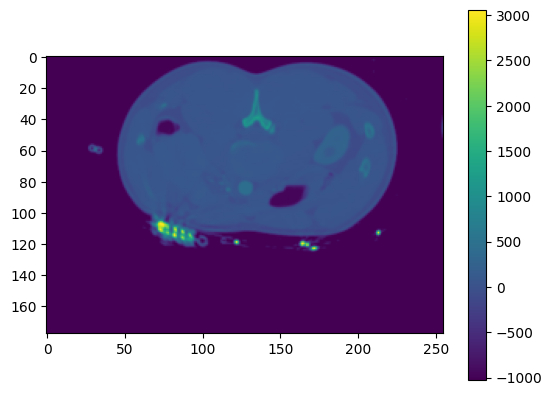

(256, 178, 255)
115
[277 225 320 285]
-175.0 275.0


File_name                                                  000083_04_01_115.png
Patient_index                                                                83
Study_index                                                                   4
Series_ID                                                                     1
Key_slice_index                                                             115
Measurement_coordinates       230.778, 307.704, 280.381, 292.992, 271.553, 3...
Bounding_boxes                               225.778, 277.903, 285.381, 320.271
Lesion_diameters_Pixel_                                        51.7385, 34.8925
Normalized_lesion_location                         0.482551, 0.579324, 0.814353
Coarse_lesion_type                                                           -1
Possibly_noisy                                                                0
Slice_range                                                            109, 121
Spacing_mm_px_                          

In [53]:
plt.imshow(nii_image_data[12,:,:], cmap='viridis')  # cmap define la paleta de colores
plt.colorbar()  # Añadir una barra de color para referencia
show_box(bbox, plt.gca(), edgecolor='red')
plt.show()
print(np.shape(nii_image_data))
print(key_slice_idx)
print(bbox)

print(lower_bound, upper_bound)
row

In [51]:
# save the segmentation info to a csv file
seg_info_df = pd.DataFrame(seg_info)
seg_info_df.to_csv(join(pred_save_dir, 'tiny_seg_info202412.csv'), index=False)

-175.0

/tmp/ipykernel_40253/248211859.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


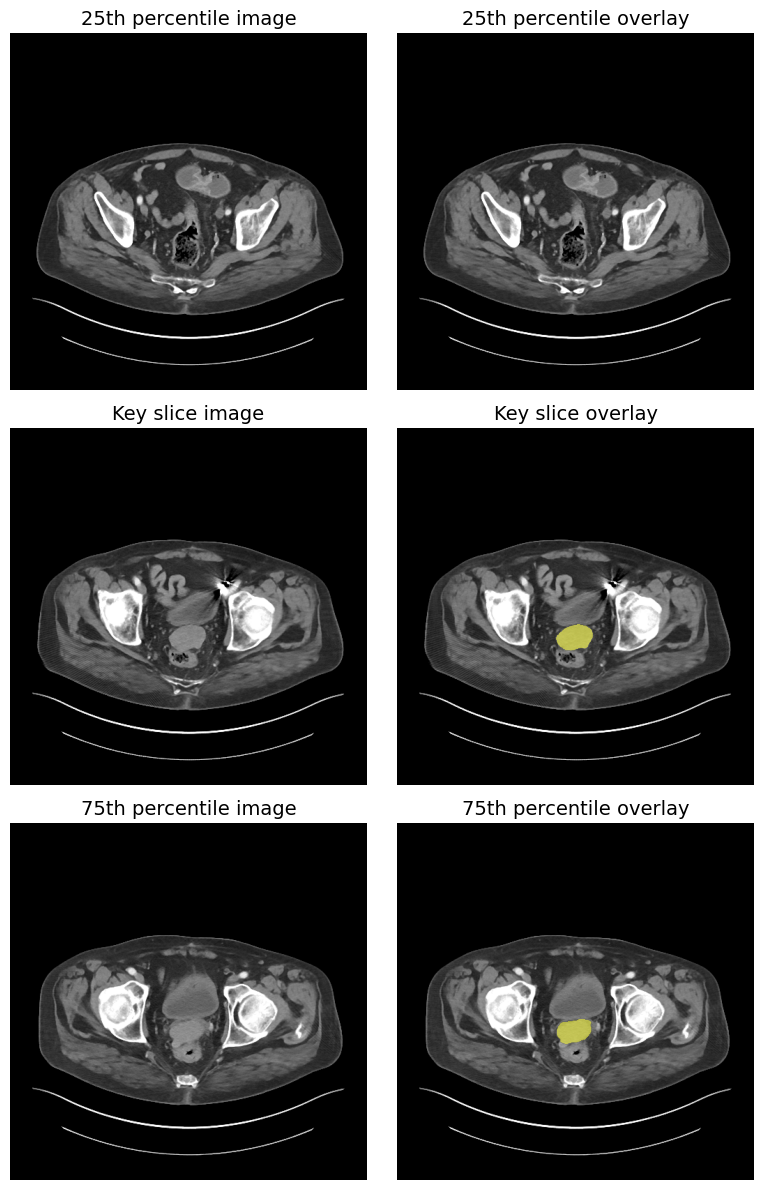

In [31]:
slice_indices = np.arange(0, slice_idx_end - slice_idx_start)
slice_idx_25 = int(np.percentile(slice_indices, 25))
slice_idx_75 = int(np.percentile(slice_indices, 75))
percentile_slices = [slice_idx_25, key_slice_idx_offset, slice_idx_75]

fig, axes = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True)
for ax in axes.flatten():
    ax.axis('off')

row_titles = ['25th percentile image', 'Key slice image', '75th percentile image']
row_titles_masks = ['25th percentile overlay', 'Key slice overlay', '75th percentile overlay']

for row_idx, slice_idx in enumerate(percentile_slices):
    imgs_2D = img_3D_ori[slice_idx].T
    imgs_2D = imgs_2D[:, :, None].repeat(3, axis=-1)
    segs_2D = segs_3D[slice_idx].T

    axes[row_idx, 0].imshow(imgs_2D, cmap='gray')
    axes[row_idx, 1].imshow(imgs_2D, cmap='gray')
    show_mask(segs_2D, ax=axes[row_idx, 1])

    axes[row_idx, 0].set_title(row_titles[row_idx], fontsize=14)
    axes[row_idx, 1].set_title(row_titles_masks[row_idx], fontsize=14)

plt.tight_layout()

In [54]:
print(key_slice_idx)
print(slice_idx_start, slice_idx_end)
print(key_slice_idx_offset)


115
109 121
6


Try infer 

In [ ]:
checkpoint = '/home/usagers/u139017/proyectos/Medsam/MedSAM2/checkpoints/MedSAM2_2411.pt'
model_cfg = "configs/sam2.1_hiera_t512.yaml" #This is the model configuration file

pred_save_dir = "/home/usagers/u139017/proyectos/Medsam/Seg_results"
imgs_path = '/home/usagers/u139017/proyectos/Medsam/imagen'  # Path to the folder containing the .NII files
os.makedirs("../Seg_results/", exist_ok=True)


Adjusting the window level changes the overall brightness of the image. For example, a high window level might make the image appear brighter, while a lower window level makes it darker. 
Adjusting the window width changes the range of grayscale values displayed. A narrow window width will result in higher contrast, highlighting subtle differences between tissues, while a wider window width will show a broader range of tissues but with less contras



In [105]:
# Nii file name used for this demo
nii_fname = sorted(os.listdir(imgs_path))[0]

seg_info = OrderedDict()
seg_info['nii_name'] = []
seg_info['key_slice_index'] = []
seg_info['DICOM_windows'] = []

print(nii_fname)

lowExtCase-100137.nii


In [ ]:
# initialized predictor
predictor = build_sam2_video_predictor_npz(model_cfg, checkpoint)

slice_range = 80,205
#print(slice_range) # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Here we need to adjust the slice range to the slices of interest. For now, this is just a test.

# nii_image = sitk.ReadImage(join(imgs_path, nii_fname))
# nii_image_data = sitk.GetArrayFromImage(nii_image)

slice_idx_start, slice_idx_end = 90, 216  # Adjust these values to the slices of interest

nii_image = sitk.ReadImage(join(imgs_path, nii_fname))
nii_image_data_full = sitk.GetArrayFromImage(nii_image)

nii_image_data = nii_image_data_full[slice_idx_start:slice_idx_end]

# To crop the sitk object, also crop the sitk image
nii_image_cropped = sitk.GetImageFromArray(nii_image_data)
#nii_image_cropped.CopyInformation(nii_image)  # keeps orientation, spacing, origin


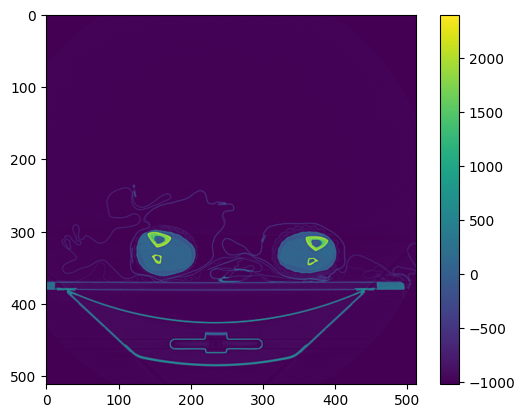

(126, 512, 512)


In [ ]:

# initialize the segmentation
segs_3D = np.zeros(nii_image_data.shape, dtype=np.uint8)    # 

plt.imshow(nii_image_data[40,:,:], cmap='viridis')  # cmap defines the color palette
plt.colorbar()  # colore reference
plt.show()
print(np.shape(nii_image_data))



In [ ]:

WC = 1120#This is the center of the contrast window, or window center in MIPAV, which is the center of the contrast window
WW = 2880 # This is the window width, or window width in MIPAV, which is the width of the contrast window
lower_bound = WC - WW / 2 
upper_bound = WC + WW / 2


nii_image_data_pre = np.clip(nii_image_data, lower_bound, upper_bound)
nii_image_data_pre = (nii_image_data_pre - np.min(nii_image_data_pre))/(np.max(nii_image_data_pre)-np.min(nii_image_data_pre))*255.0
nii_image_data_pre = np.uint8(nii_image_data_pre) # Normalize the image to the range [0, 255] for visualization



# get key slice image
key_slice_idx = 130  # THis is the index of the slice we want to process as the MAIN one.
slice_idx_start, slice_idx_end = 90,205 # the end of the slice range

bbox = np.array([136, 304, 180, 325])  # YOu need to change this value to the coordinates of the bounding box # y_min, x_min, y_max, x_max



print(nii_image_data_pre.shape)



(126, 512, 512)


In [ ]:
key_slice_idx_offset = key_slice_idx - slice_idx_start
print(key_slice_idx_offset)
key_slice_img = nii_image_data_pre[key_slice_idx_offset, :,:]


img_3D_ori = nii_image_data_pre
assert np.max(img_3D_ori) < 256, f'input data should be in range [0, 255], but got {np.unique(img_3D_ori)}' # Check if the input data is in the range [0, 255]

40


In [ ]:
video_height = key_slice_img.shape[0] # height of the key slice image
video_width = key_slice_img.shape[1]

print(video_height, video_width)

512 512


In [ ]:
img_resized = resize_grayscale_to_rgb_and_resize(img_3D_ori, 512)
img_resized = img_resized / 255.0
img_resized = torch.from_numpy(img_resized).cuda()
img_mean=(0.485, 0.456, 0.406)
img_std=(0.229, 0.224, 0.225) # Here we define the mean and standard deviation for the image normalization
img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None].cuda()
img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None].cuda() 
img_resized -= img_mean
img_resized /= img_std
z_mids = []


# at this point we have the image and the segmentation initialized, now we are going to make the segmentation prediction with the MedSAM2 model

In [ ]:
#Obtain the segmentation prediction with the MedSAM2 model

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    inference_state = predictor.init_state(img_resized, video_height, video_width)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                        )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                    )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, reverse=True):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)
if np.max(segs_3D) > 0:
    segs_3D = getLargestCC(segs_3D)
    segs_3D = np.uint8(segs_3D)
sitk_image = sitk.GetImageFromArray(img_3D_ori)
sitk_image.CopyInformation(nii_image_cropped)
sitk_mask = sitk.GetImageFromArray(segs_3D)
sitk_mask.CopyInformation(nii_image_cropped) #

propagate in video: 100%|██████████| 41/41 [00:00<00:00, 130.28it/s]


In [ ]:
#key_slice_idx = row['Key_slice_index'] #Lo cambiaremos a la q ya habiamos eledo antes, o sea, a la que queremos procesar.
#save_seg_name = nii_fname.split('.nii.gz')[0] + f'_k{key_slice_idx}_mask.nii.gz' # We can change the name to another name, or to the one we want.
save_seg_name = 'OjalaFuncione.nii.gz' #Aui podemos cambiar el nombre a otro nombre, o sea, al que queramos.


sitk.WriteImage(sitk_image, os.path.join(pred_save_dir, nii_fname.replace('.nii.gz', '_img.nii.gz'))) #Sve the original image with the same name but with _img.nii.gz suffix
sitk.WriteImage(sitk_mask, os.path.join(pred_save_dir, save_seg_name)) #Save the segmentation mask with the specified name
seg_info['nii_name'].append(save_seg_name) 
seg_info['key_slice_index'].append(key_slice_idx)
seg_info['DICOM_windows'].append([lower_bound,upper_bound]) #


In [ ]:
# save the segmentation info to a csv file
seg_info_df = pd.DataFrame(seg_info)
seg_info_df.to_csv(join(pred_save_dir, 'tiny_seg_info202412.csv'), index=False) #Create a DataFrame from the segmentation info and save it to a CSV file

we can visualize the segmentations.

/tmp/ipykernel_40253/3775891903.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


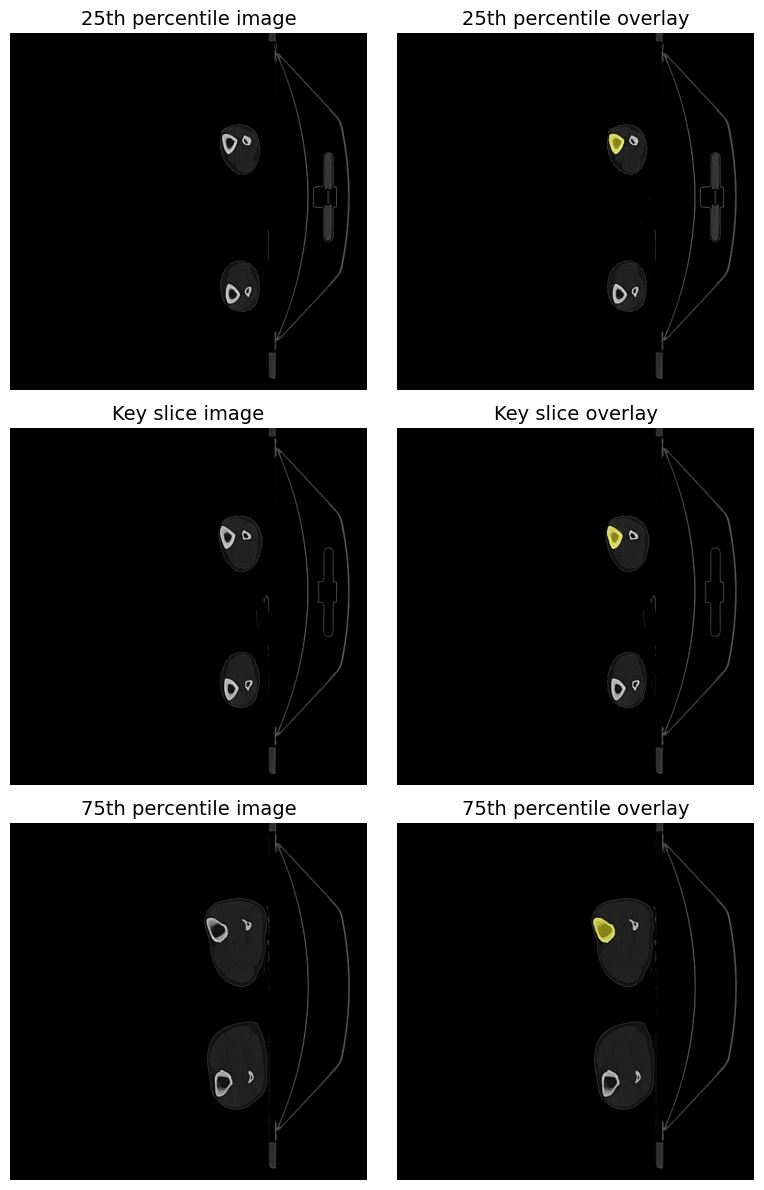

In [151]:
slice_indices = np.arange(0, slice_idx_end - slice_idx_start)
slice_idx_25 = int(np.percentile(slice_indices, 25))
slice_idx_75 = int(np.percentile(slice_indices, 75))
percentile_slices = [slice_idx_25, key_slice_idx_offset, slice_idx_75]


fig, axes = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True)
for ax in axes.flatten():
    ax.axis('off')

row_titles = ['25th percentile image', 'Key slice image', '75th percentile image']
row_titles_masks = ['25th percentile overlay', 'Key slice overlay', '75th percentile overlay']

for row_idx, slice_idx in enumerate(percentile_slices):
    imgs_2D = img_3D_ori[slice_idx].T
    imgs_2D = imgs_2D[:, :, None].repeat(3, axis=-1)
    segs_2D = segs_3D[slice_idx].T

    axes[row_idx, 0].imshow(imgs_2D, cmap='gray')
    axes[row_idx, 1].imshow(imgs_2D, cmap='gray')
    show_mask(segs_2D, ax=axes[row_idx, 1])

    axes[row_idx, 0].set_title(row_titles[row_idx], fontsize=14)
    axes[row_idx, 1].set_title(row_titles_masks[row_idx], fontsize=14)

plt.tight_layout()